In [1]:
import tensorflow as tf
import numpy as np
from gbica_utils import *
from tf_powersfa import *
from tensorflow.keras.layers import *
from tensorflow.nn import *

In [2]:
n_out = 3

In [3]:
N = 1000

encoding_x = tf.placeholder("float", [N,3])

with tf.name_scope("encoder"):
    dense0 = tf.keras.layers.Dense(n_out)(encoding_x)
encoder_var_list = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='encoder')

dense = alt_power_whitening(dense0, n_out, 50)[0]

In [4]:
n_hidden = 32

y1, y2, y3 = tf.split(dense, n_out, axis=1)

In [5]:
x1 = tf.concat([y2, y3], axis=1)
y_1 = permute_y(y1, N)

x2 = tf.concat([y1, y3], axis=1)
y_2 = permute_y(y2, N)

x3 = tf.concat([y1, y2], axis=1)
y_3 = permute_y(y3, N)

h_join1 = tf.concat([y1, x1], axis=1)
h_marg1 = tf.concat([y_1, x1], axis=1)

h_join2 = tf.concat([y2, x2], axis=1)
h_marg2 = tf.concat([y_2, x2], axis=1)

h_join3 = tf.concat([y3, x3], axis=1)
h_marg3 = tf.concat([y_3, x3], axis=1)

def estimator_net_merge(h_join, h_marg):
    dense1_joint = leaky_relu(estimator1(h_join))
    dense2_joint = leaky_relu(estimator2(dense1_joint))
    dense3_joint = leaky_relu(estimator3(dense2_joint))
    dense4_joint = leaky_relu(estimator4(dense3_joint))
    dense5_joint = leaky_relu(estimator5(dense4_joint))
    dense6_joint = leaky_relu(estimator6(dense5_joint))
    dense7_joint = estimator7(dense6_joint)

    dense1_marg = leaky_relu(estimator1(h_marg))
    dense2_marg = leaky_relu(estimator2(dense1_marg))
    dense3_marg = leaky_relu(estimator3(dense2_marg))
    dense4_marg = leaky_relu(estimator4(dense3_marg))
    dense5_marg = leaky_relu(estimator4(dense4_marg))
    dense6_marg = leaky_relu(estimator4(dense5_marg))
    dense7_marg = estimator7(dense6_marg)
    
    return dense7_joint, dense7_marg

with tf.name_scope("estimator"):   
    estimator1 = Dense(n_hidden)
    estimator2 = Dense(n_hidden)
    estimator3 = Dense(n_hidden)
    estimator4 = Dense(n_hidden)
    estimator5 = Dense(n_hidden)
    estimator6 = Dense(n_hidden)
    estimator7 = Dense(n_hidden)
    dense7_joint, dense7_marg = estimator_net_merge(h_join1, h_marg1)
    dense7_joint2, dense7_marg2 = estimator_net_merge(h_join2, h_marg2)
    dense7_joint3, dense7_marg3 = estimator_net_merge(h_join3, h_marg3)

estimator_var_list = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='estimator')
print(estimator_var_list)
loss1 = tf.reduce_mean(dense7_joint)-tf.log(tf.reduce_mean(tf.exp(dense7_marg)))
loss2 = tf.reduce_mean(dense7_joint2)-tf.log(tf.reduce_mean(tf.exp(dense7_marg2)))
loss3 = tf.reduce_mean(dense7_joint3)-tf.log(tf.reduce_mean(tf.exp(dense7_marg3)))

[<tf.Variable 'estimator/dense_1/kernel:0' shape=(3, 32) dtype=float32>, <tf.Variable 'estimator/dense_1/bias:0' shape=(32,) dtype=float32>, <tf.Variable 'estimator/dense_2/kernel:0' shape=(32, 32) dtype=float32>, <tf.Variable 'estimator/dense_2/bias:0' shape=(32,) dtype=float32>, <tf.Variable 'estimator/dense_3/kernel:0' shape=(32, 32) dtype=float32>, <tf.Variable 'estimator/dense_3/bias:0' shape=(32,) dtype=float32>, <tf.Variable 'estimator/dense_4/kernel:0' shape=(32, 32) dtype=float32>, <tf.Variable 'estimator/dense_4/bias:0' shape=(32,) dtype=float32>, <tf.Variable 'estimator/dense_5/kernel:0' shape=(32, 32) dtype=float32>, <tf.Variable 'estimator/dense_5/bias:0' shape=(32,) dtype=float32>, <tf.Variable 'estimator/dense_6/kernel:0' shape=(32, 32) dtype=float32>, <tf.Variable 'estimator/dense_6/bias:0' shape=(32,) dtype=float32>, <tf.Variable 'estimator/dense_7/kernel:0' shape=(32, 32) dtype=float32>, <tf.Variable 'estimator/dense_7/bias:0' shape=(32,) dtype=float32>]


In [6]:
estimator_loss = -(loss1+loss2+loss3)

total_encoder_loss = loss1+loss2+loss3
encoder_lr = 0.005

train_encoders = tf.train.AdamOptimizer(encoder_lr).minimize(total_encoder_loss, var_list=encoder_var_list)

regularizer = tf.contrib.layers.l2_regularizer(scale=0.1)

for var in estimator_var_list:
    tf.add_to_collection(tf.GraphKeys.REGULARIZATION_LOSSES, var)
reg_variables = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
reg_term = tf.contrib.layers.apply_regularization(regularizer, reg_variables)
estimator_loss += reg_term
train_estimators =  tf.contrib.opt.NadamOptimizer(0.0005).minimize(estimator_loss, var_list=estimator_var_list) 

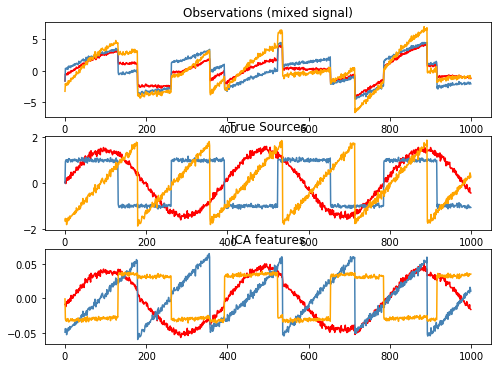

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import FastICA
from scipy import signal

time = np.linspace(0, 8, N)

s1 = np.sin(2 * time)                       # Signal 1 : sinusoidal signal
s2 = np.sign(np.sin(3 * time))              # Signal 2 : square signal
s3 = signal.sawtooth(1.4 * np.pi * time)    # Signal 3 : saw tooth signal

S = np.c_[s1, s2, s3]
S += 0.05 * np.random.normal(size=S.shape)  # Add noise

S /= S.std(axis=0)  # Standardize data
# Mix data
A = np.array([[1  , 1, 1],
              [0.5, 2, 1.0],
              [1.5, 1.0, 2.0]])  # Mixing matrixX = np.dot(S, A.T)  # Generate observations
X = np.dot(S, A.T)  # Generate observations

# Solve the task with FastICA
ica = FastICA(n_components=3)
S_ = ica.fit_transform(X)  # Reconstruct signals


models = [X, S, S_]
names = ['Observations (mixed signal)', 'True Sources', 'ICA features']
colors = ['red', 'steelblue', "orange"]
plt.figure(figsize=(8, 8))
for ii, (model, name) in enumerate(zip(models, names), 1):
    plt.subplot(4, 1, ii)
    plt.title(name)
    for sig, color in zip(model.T, colors):
        plt.plot(sig, color=color)
plt.show()

In [8]:
shuffled_x = np.array(X)


step: 0, loss1: -0.042, loss2: -0.045, loss3: -0.042, all_loss: -0.13


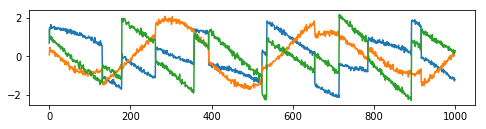

step: 10, loss1: -0.0057, loss2: -0.0068, loss3: -0.0057, all_loss: -0.018
step: 20, loss1: 0.011, loss2: 0.011, loss3: 0.011, all_loss: 0.033
step: 30, loss1: 0.023, loss2: 0.023, loss3: 0.023, all_loss: 0.07
step: 40, loss1: 0.035, loss2: 0.035, loss3: 0.035, all_loss: 0.11


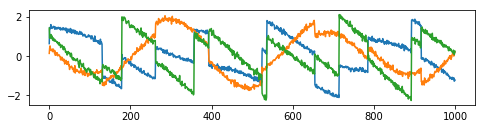

step: 50, loss1: 0.049, loss2: 0.05, loss3: 0.049, all_loss: 0.15
step: 60, loss1: 0.067, loss2: 0.068, loss3: 0.067, all_loss: 0.2
step: 70, loss1: 0.093, loss2: 0.094, loss3: 0.093, all_loss: 0.28
step: 80, loss1: 0.13, loss2: 0.13, loss3: 0.13, all_loss: 0.4


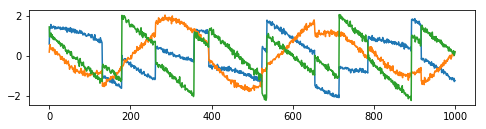

step: 90, loss1: 0.2, loss2: 0.2, loss3: 0.2, all_loss: 0.6
step: 100, loss1: 0.32, loss2: 0.33, loss3: 0.32, all_loss: 0.98
step: 110, loss1: 0.59, loss2: 0.6, loss3: 0.59, all_loss: 1.8
step: 120, loss1: 1.2, loss2: 1.2, loss3: 1.2, all_loss: 3.6


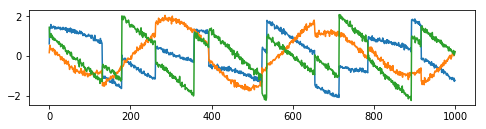

step: 130, loss1: 2.7, loss2: 2.7, loss3: 2.7, all_loss: 8.1
step: 140, loss1: 6.3, loss2: 6.4, loss3: 6.2, all_loss: 1.9e+01
step: 150, loss1: 1.5e+01, loss2: 1.5e+01, loss3: 1.5e+01, all_loss: 4.4e+01
step: 160, loss1: 3.4e+01, loss2: 3.5e+01, loss3: 3.4e+01, all_loss: 1e+02


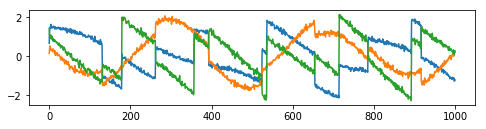

step: 170, loss1: 7.7e+01, loss2: 7.9e+01, loss3: 7.7e+01, all_loss: 2.3e+02
step: 180, loss1: 1.7e+02, loss2: 1.7e+02, loss3: 1.7e+02, all_loss: 5e+02
step: 190, loss1: nan, loss2: nan, loss3: nan, all_loss: nan
step: 200, loss1: nan, loss2: nan, loss3: nan, all_loss: nan


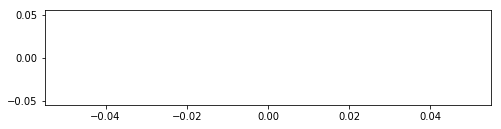

step: 210, loss1: nan, loss2: nan, loss3: nan, all_loss: nan
step: 220, loss1: nan, loss2: nan, loss3: nan, all_loss: nan
step: 230, loss1: nan, loss2: nan, loss3: nan, all_loss: nan
step: 240, loss1: nan, loss2: nan, loss3: nan, all_loss: nan


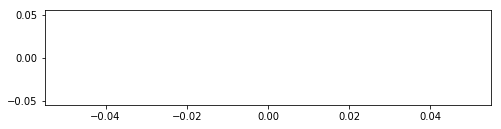

step: 250, loss1: nan, loss2: nan, loss3: nan, all_loss: nan
step: 260, loss1: nan, loss2: nan, loss3: nan, all_loss: nan
step: 270, loss1: nan, loss2: nan, loss3: nan, all_loss: nan
step: 280, loss1: nan, loss2: nan, loss3: nan, all_loss: nan


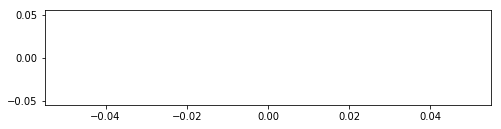

step: 290, loss1: nan, loss2: nan, loss3: nan, all_loss: nan
step: 300, loss1: nan, loss2: nan, loss3: nan, all_loss: nan
step: 310, loss1: nan, loss2: nan, loss3: nan, all_loss: nan
step: 320, loss1: nan, loss2: nan, loss3: nan, all_loss: nan


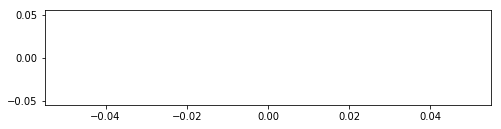

step: 330, loss1: nan, loss2: nan, loss3: nan, all_loss: nan
step: 340, loss1: nan, loss2: nan, loss3: nan, all_loss: nan
step: 350, loss1: nan, loss2: nan, loss3: nan, all_loss: nan
step: 360, loss1: nan, loss2: nan, loss3: nan, all_loss: nan


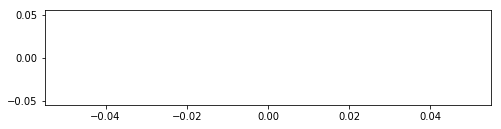

step: 370, loss1: nan, loss2: nan, loss3: nan, all_loss: nan
step: 380, loss1: nan, loss2: nan, loss3: nan, all_loss: nan
step: 390, loss1: nan, loss2: nan, loss3: nan, all_loss: nan


KeyboardInterrupt: 

In [9]:
from random import shuffle
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    for i in range(4001):
        np.random.shuffle(shuffled_x)
        current_loss1, current_loss2, current_loss3, _ = sess.run([loss1,
                                                    loss2, loss3, train_estimators], feed_dict={encoding_x:shuffled_x})

        if i % 7   is 0: 
            _ = sess.run(train_encoders, feed_dict={encoding_x:shuffled_x})

        if i % 10 is 0: 
            print("step: {}, loss1: {:.2}, loss2: {:.2}, loss3: {:.2}, all_loss: {:.2}".format(i,
                                current_loss1, current_loss2, current_loss3, current_loss1+current_loss2+current_loss3))
        if i % 40 is 0:
            plt.figure(figsize=(8, 8))
            plt.subplot(4, 1, 1)
            encoding = sess.run(dense, feed_dict={encoding_x:X})
            plt.plot(encoding)
            plt.show()